In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astroquery.simbad import Simbad
import arviz as az
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet
plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

01_31_25


In [2]:
files = glob.glob('../data/P112_data/*.fits')

In [3]:
hdul = fits.open(files[0])

header  = hdul[0].header
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f858889e7c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f858a801550>]

In [20]:
header


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-04-08T08:28:23' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
OBJECT  = 'UCAC4 202-005918'   / Original target.                               
RA      =            81.645124 / [deg] Spectroscopic target position (J2000)    
DEC     =            -49.78464 / [deg] Spectroscopic target position (J2000)    
EXPTIME =                 300. / [s] Total integration time per pixel           
MJD-OBS =       60373.013403

In [4]:
data    = hdul[1].data


In [5]:
len(data['SNR     '][0]),len(data['FLUX    '][0])

(443262, 443262)

In [6]:
li_line = 6707.926

[53.7010931002614, 53.7985038354756, 53.7157728358864, 53.4587722172283]
49.63067151488309 53.7010931002614 1.2007431954522136
50.63150325292816 53.7985038354756 1.2029212754636218
50.13108696659508 53.7157728358864 1.201071430719787
49.13025689771084 53.4587722172283 1.195324960280078


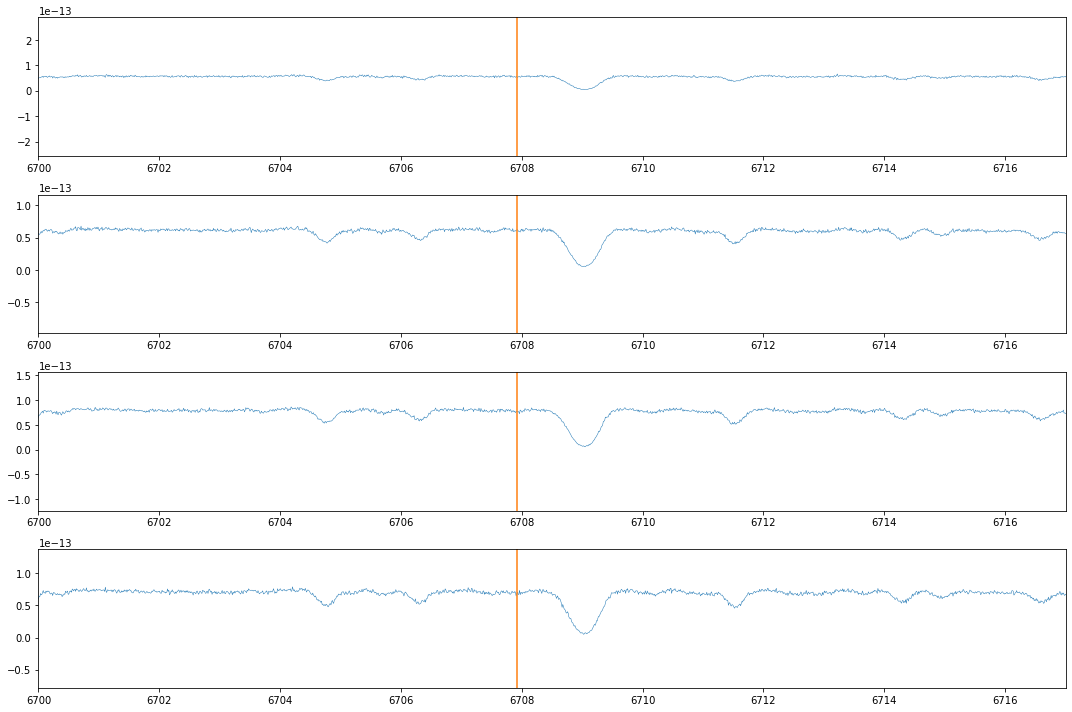

In [23]:
def spectra(rg):
    c = 3e5 #km/s
    files = obj_dir[rg]['file']
    rvs    = obj_dir[rg]['rv']
    print(rvs)
    plt.figure(figsize=(15,10))
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
                
            hdul = fits.open(file)
            header = hdul[0].header
            data  = hdul[1].data
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
            mask       = (wave > 3800)
            wave, flux = wave[mask], flux[mask]
            plt.subplot(len(files),1,i+1)
            plt.plot(wave, flux, lw=0.5)
            plt.axvline(li_line,c='C1')
            plt.xlim(6700, 6717)
            mask = (wave >= 6708) & (wave <= 6710)
            new_wave = wave[mask]
            new_flux = flux[mask]
            w0 = li_line*1
            w1 = new_wave[np.argmin(new_flux)]
            shift = (rv_val/c)*(w0)
            print((w1 - w0)*c/w0, rv_val, shift)
            #plt.scatter(w1, np.min(new_flux))
#             plt.plot(wave-shift, flux, lw=0.5)
            
    plt.tight_layout()
    plt.show()
spectra(1)

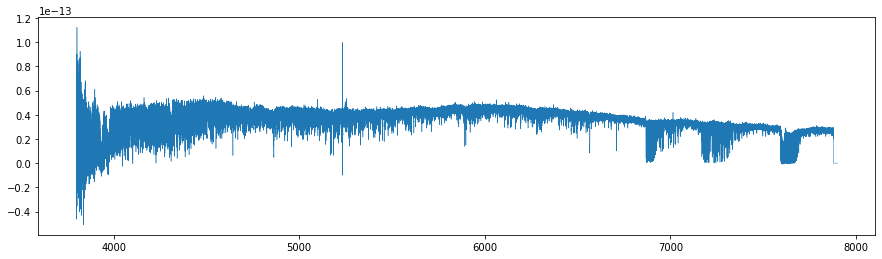

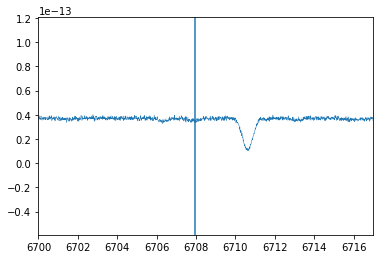

In [44]:
plt.figure(figsize=(15,4))
wave, flux = data['WAVE    '][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]
plt.plot(wave, flux,lw=0.5)
plt.show()

plt.figure(figsize=(6,4))
wave, flux = data['WAVE    '][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]
plt.plot(wave, flux,lw=0.5)
plt.xlim(6700, 6717)
plt.axvline(li_line)
plt.show()
# plt.axvline(3800)

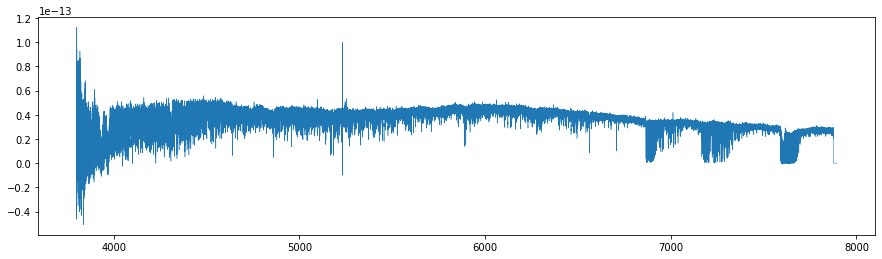

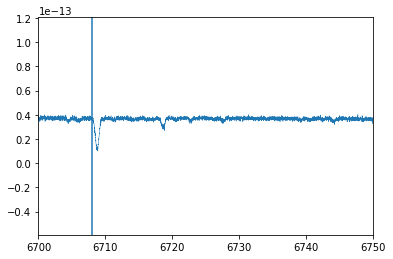

In [42]:
plt.figure(figsize=(15,4))
wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]
plt.plot(wave, flux,lw=0.5)
plt.show()

plt.figure(figsize=(6,4))
wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]
plt.plot(wave, flux,lw=0.5)
plt.xlim(6700, 6750)
plt.axvline(li_line)

plt.show()
# plt.axvline(3800)

In [8]:
def get_files():
    obj_dir = {}
    c=3e5 #km/s

    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            grade   = header['OB_GRADE'].replace(" ", "")
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err
            # correct for Earth's motion:
    #         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
    #         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
    #         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
            #err_corr = rv_err + err_corr + rv_err * err_corr / c  

            if obj in obj_dir.keys():
                obj_dir[obj]['file'].append(file)
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
            else:
                obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade]}
    print(len(obj_dir.keys()))   
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}
    return obj_dir
obj_dir = get_files()

RG 20 C
RG 13 C
RG 14 C
RG 1 C
19
10
